In [ ]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### get the file from here:
### https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/mjsynth_sample.zip

In [ ]:
!wget https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/mjsynth_sample.zip

--2020-06-25 17:55:09--  https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/mjsynth_sample.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘mjsynth_sample.zip’

mjsynth_sample.zip      [ <=>                ]  73.81K  --.-KB/s    in 0.03s   

2020-06-25 17:55:09 (2.50 MB/s) - ‘mjsynth_sample.zip’ saved [75582]



In [ ]:
## execute the below command
!unzip -qq /content/drive/My\ Drive/mjsynth_sample.zip

In [ ]:
final_paths = []
final_texts = []

data_folder = "mjsynth_sample"
for path in os.listdir(data_folder):


    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split("_")[1])





In [ ]:
final_paths[:10], final_texts[:10]

(['mjsynth_sample/96_confusedly_16004.jpg',
  'mjsynth_sample/38_Nu_52489.jpg',
  'mjsynth_sample/398_sodomizing_72500.jpg',
  'mjsynth_sample/173_REDOLENCE_63579.jpg',
  'mjsynth_sample/86_BELLICOSITY_6857.jpg',
  'mjsynth_sample/1_UNEQUIVOCALLY_82397.jpg',
  'mjsynth_sample/231_Inferiors_39307.jpg',
  'mjsynth_sample/135_atty_4765.jpg',
  'mjsynth_sample/281_COMPLEXLY_15479.jpg',
  'mjsynth_sample/174_COTTONSEEDS_17355.jpg'],
 ['confusedly',
  'Nu',
  'sodomizing',
  'REDOLENCE',
  'BELLICOSITY',
  'UNEQUIVOCALLY',
  'Inferiors',
  'atty',
  'COMPLEXLY',
  'COTTONSEEDS'])

In [ ]:
### get vocab from dataset
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
Counter("".join(map(str, final_texts)))

Counter({'0': 38,
         '1': 56,
         '2': 30,
         '3': 21,
         '4': 26,
         '5': 16,
         '6': 16,
         '7': 15,
         '8': 17,
         '9': 10,
         'A': 12188,
         'B': 3874,
         'C': 7202,
         'D': 6379,
         'E': 16729,
         'F': 2799,
         'G': 4768,
         'H': 3898,
         'I': 12696,
         'J': 518,
         'K': 1611,
         'L': 7997,
         'M': 4745,
         'N': 10222,
         'O': 8783,
         'P': 5178,
         'Q': 350,
         'R': 11125,
         'S': 14094,
         'T': 10070,
         'U': 4990,
         'V': 1787,
         'W': 1806,
         'X': 428,
         'Y': 2289,
         'Z': 696,
         'a': 21612,
         'b': 4718,
         'c': 10014,
         'd': 9727,
         'e': 31936,
         'f': 3274,
         'g': 8370,
         'h': 6096,
         'i': 24247,
         'j': 453,
         'k': 2761,
         'l': 14693,
         'm': 6928,
         'n': 20242,
         'o'

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [ ]:
encode_to_labels("HELLO")

[17, 14, 21, 21, 24]

In [ ]:
train_final_paths = final_paths[ : int(len(final_paths) * 0.90)]
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)]

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ]

In [ ]:
len(train_final_paths), len(val_final_paths)

(47427, 5270)

In [ ]:
max_label_len = max([len(str(text)) for text in final_texts])

In [ ]:
max_label_len

23

In [ ]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):
            
            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)   

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:
                
                pass

        return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))

In [ ]:
train_final_paths[:1], train_final_texts[:1]

(['mjsynth_sample/459_loyalties_45457.jpg'], ['loyalties'])

In [ ]:
!nvidia-smi

Sun Dec  6 07:52:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 256
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
val_generator = My_Generator(val_final_paths, val_final_texts, batch_size)

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 64)        

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
file_path = "C_LSTM_best.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')


checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

In [ ]:
epochs = 20

history = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/20
 47/185 [======>.......................] - ETA: 24s - loss: 35.9428

KeyboardInterrupt: ignored

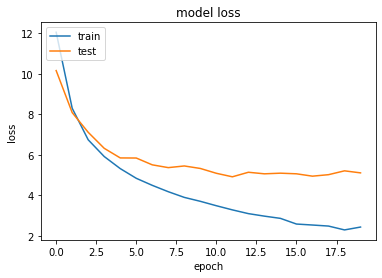

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def pre_process_image(path):
    
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))

    
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.
    
    return img

In [ ]:
act_model.load_weights('best.hdf5')

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        #print("predicted text = ", end = '')
        temp=""
        for p in x:

            if int(p) != -1:
                temp+=char_list[int(p)]
                #print(char_list[int(p)], end = '')
        
        #print("\n",temp,'\n')
        return temp

In [ ]:
val_final_paths[:5]

['mjsynth_sample/389_ISRAEL_40977.jpg',
 'mjsynth_sample/199_Fascinates_28181.jpg',
 'mjsynth_sample/124_Enemas_25723.jpg',
 'mjsynth_sample/206_Crooned_18230.jpg',
 'mjsynth_sample/411_LINDER_44595.jpg']

In [ ]:

final_paths = []
final_texts = []

data_folder = "yolo_test"
for path in os.listdir(data_folder):


    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split(".png")[0])


In [ ]:
final_paths[:3],final_texts[:3]

(['yolo_test/power.png', 'yolo_test/beaver84.png', 'yolo_test/queen.png'],
 ['power', 'beaver84', 'queen'])

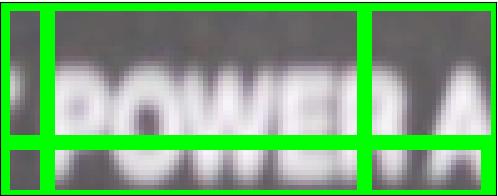


 original power 

predicted text = lpoepn
 lpoepn 



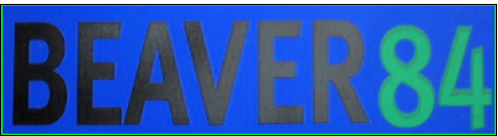


 original beaver84 

predicted text = BEATErCL
 BEATErCL 



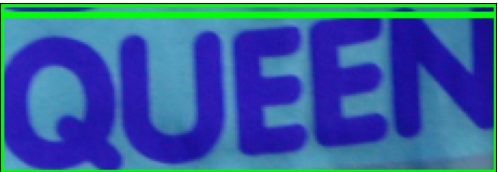


 original queen 

predicted text = QUEEN
 QUEEN 



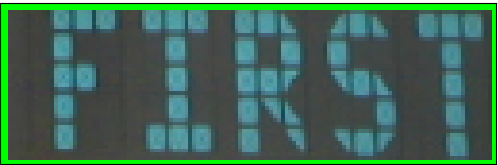


 original first 

predicted text = PATROY
 PATROY 



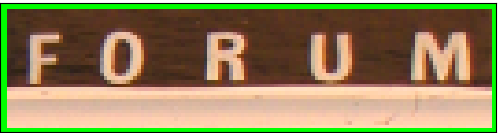


 original forum 

predicted text = BORUM
 BORUM 



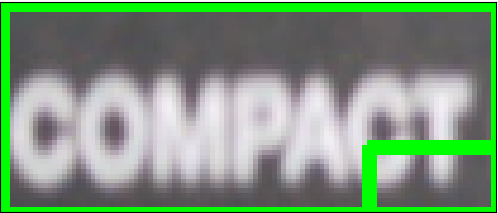


 original compact 

predicted text = COMpacY
 COMpacY 



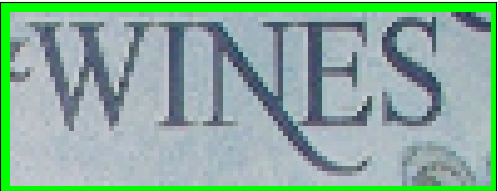


 original wines 

predicted text = EWINEST
 EWINEST 



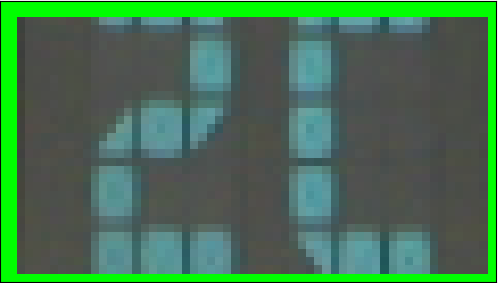


 original 2C 

predicted text = PERTET
 PERTET 



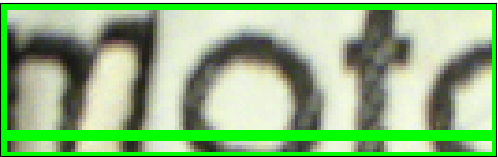


 original moto 

predicted text = Fhtd
 Fhtd 



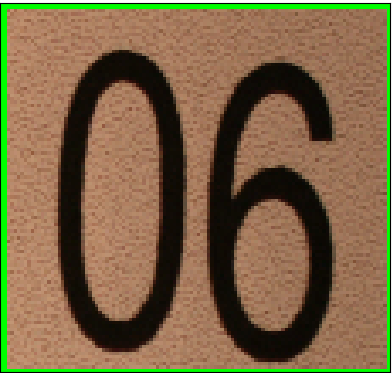


 original 06 

predicted text = Ps
 Ps 



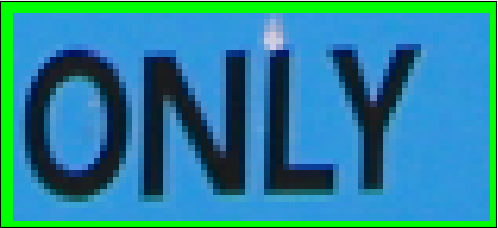


 original only 

predicted text = OnLYY
 OnLYY 



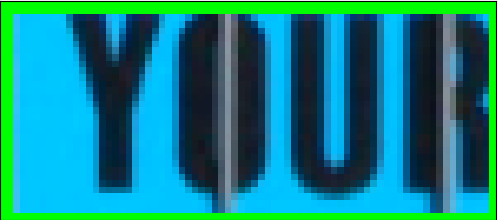


 original your 

predicted text = maDUER
 maDUER 



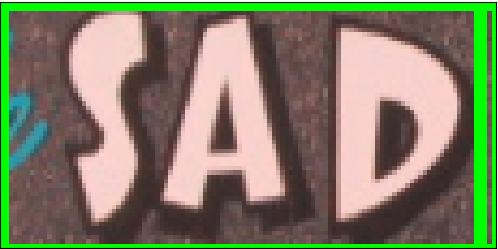


 original sad 

predicted text = SAD
 SAD 



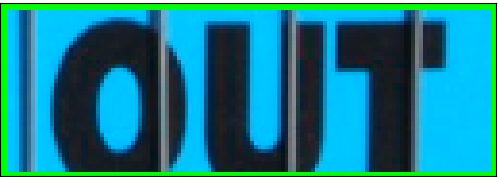


 original out 

predicted text = louie
 louie 



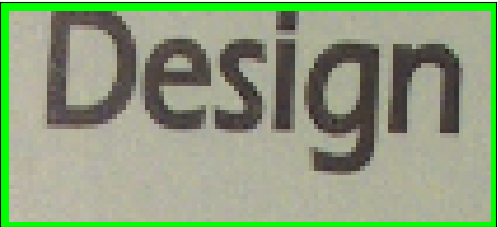


 original design 

predicted text = Design
 Design 



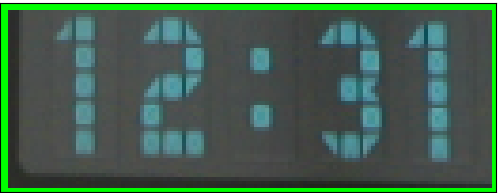


 original 12 : 31 

predicted text = LFETH
 LFETH 



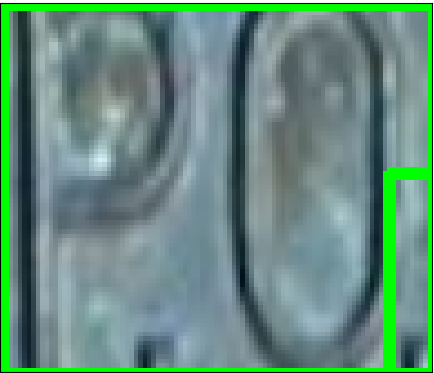


 original P.O 

predicted text = IER
 IER 



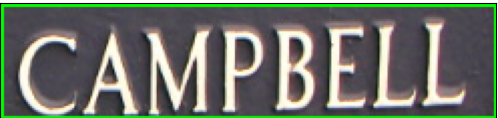


 original campbell 

predicted text = CAMPBELL
 CAMPBELL 



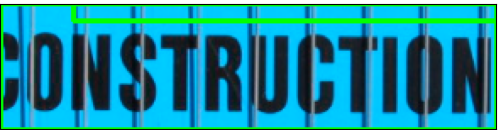


 original construction 

predicted text = bonsiructionn
 bonsiructionn 



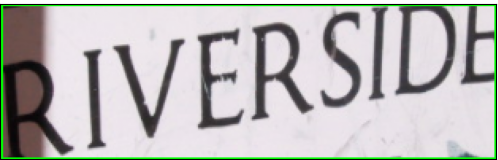


 original Riverside 

predicted text = RIVERSIDE
 RIVERSIDE 



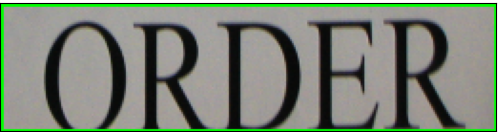


 original order 

predicted text = ORDER
 ORDER 



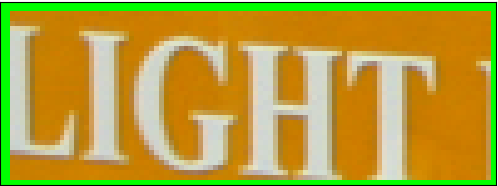


 original light 

predicted text = LGHyRi
 LGHyRi 



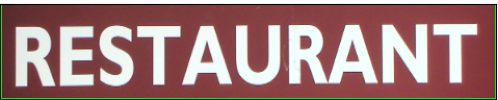


 original restaurant 

predicted text = RESTAURANT
 RESTAURANT 



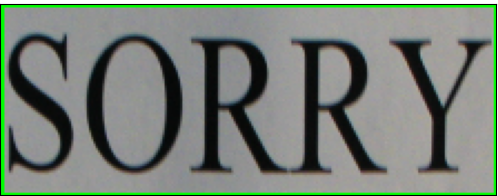


 original sorry 

predicted text = SORRY
 SORRY 



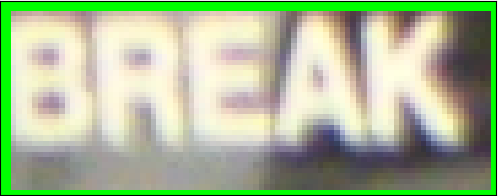


 original break 

predicted text = BIREAK
 BIREAK 



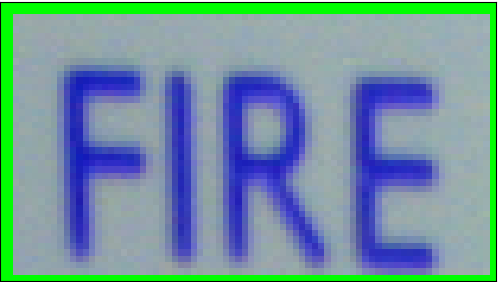


 original fire 

predicted text = FIRE
 FIRE 



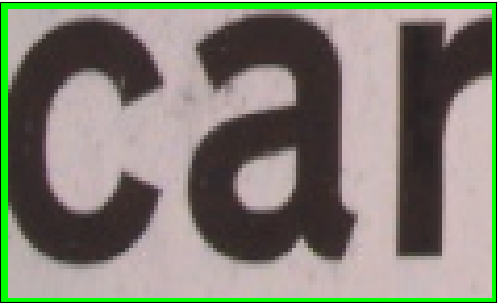


 original car 

predicted text = cn
 cn 



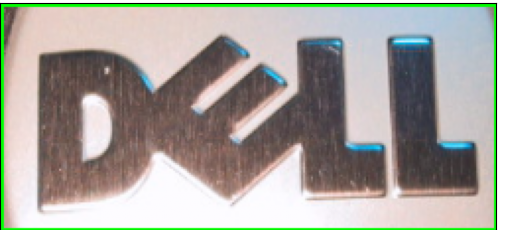


 original dell 

predicted text = DoilL
 DoilL 



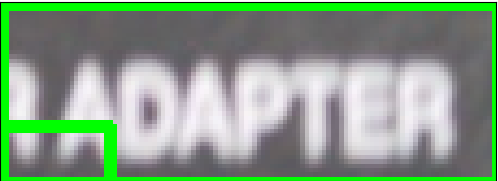


 original adapter 

predicted text = hADAPTERY
 hADAPTERY 



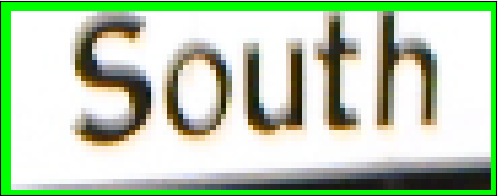


 original south 

predicted text = Bouth
 Bouth 



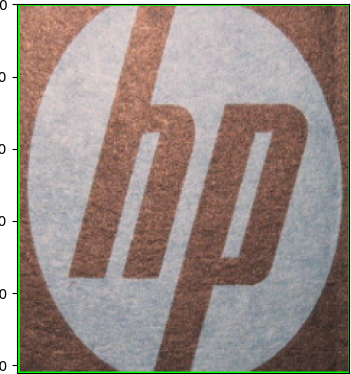


 original hp 

predicted text = Eas
 Eas 



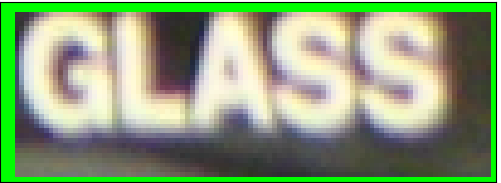


 original glas 

predicted text = ILASSY
 ILASSY 



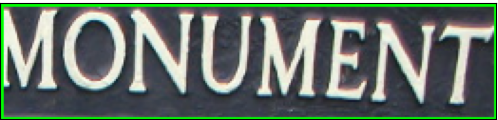


 original monument 

predicted text = MONUMENT
 MONUMENT 



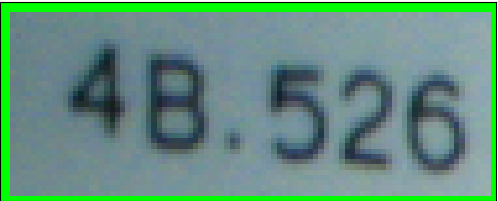


 original 4b.526 

predicted text = raBsRs
 raBsRs 



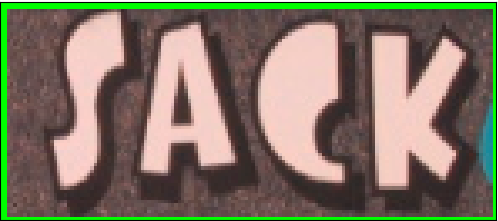


 original sack 

predicted text = TACK
 TACK 



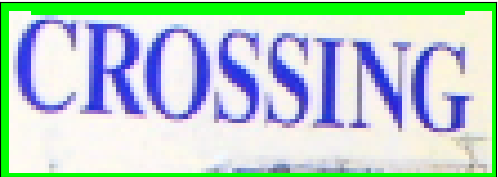


 original crossing 

predicted text = CROSSING
 CROSSING 



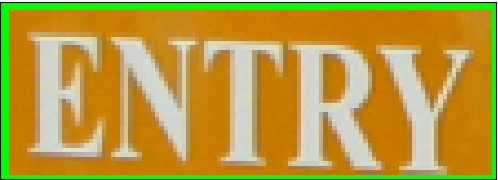


 original entry 

predicted text = ENTRY
 ENTRY 



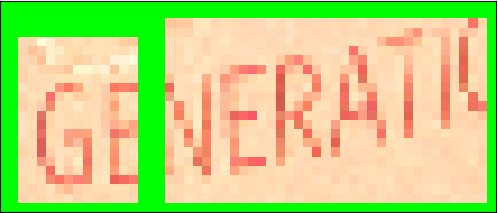


 original generation 

predicted text = CEVERATL
 CEVERATL 



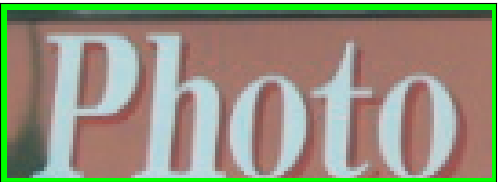


 original photo 

predicted text = pphotoo
 pphotoo 



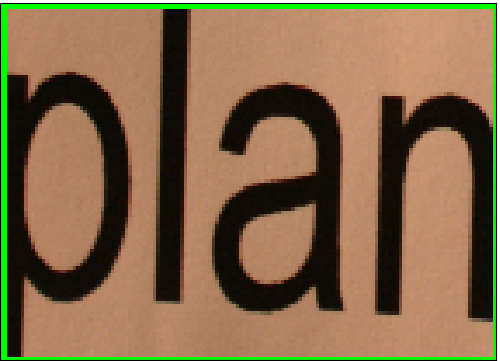


 original plan 

predicted text = Dlan
 Dlan 



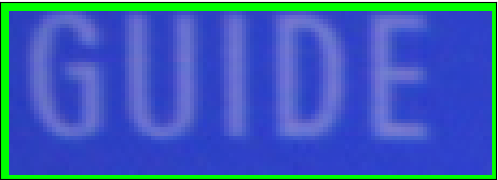


 original guide 

predicted text = TUDET
 TUDET 



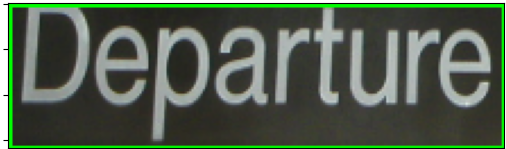


 original Departure 

predicted text = Departure
 Departure 



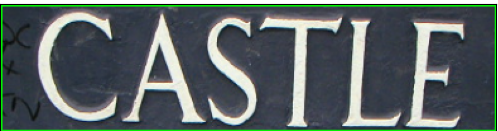


 original castle 

predicted text = CASTLE
 CASTLE 



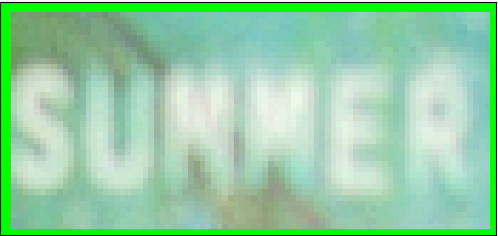


 original summer 

predicted text = suneR
 suneR 



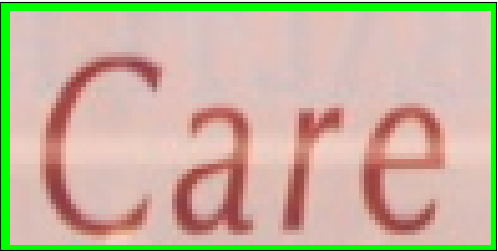


 original care 

predicted text = Care
 Care 



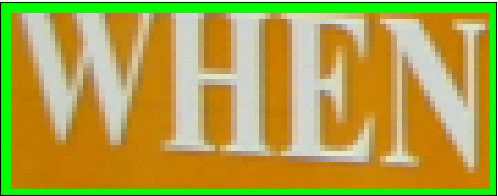


 original when 

predicted text = WEEN
 WEEN 



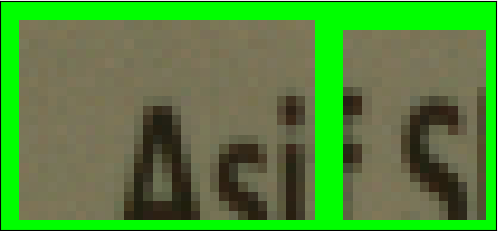


 original asif 

predicted text = Pcecd
 Pcecd 



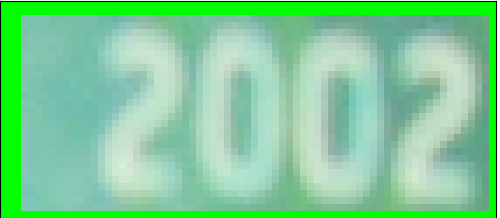


 original 2002 

predicted text = ERDOp
 ERDOp 



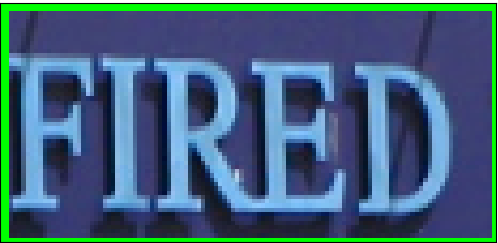


 original fired 

predicted text = FIRED
 FIRED 



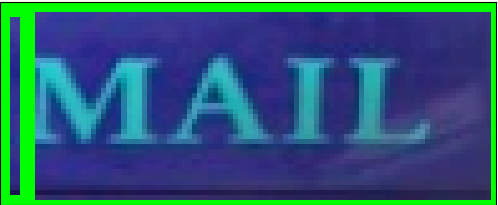


 original mail 

predicted text = INTATTY
 INTATTY 



In [ ]:
from IPython.display import display
from random import randrange
actual=[]
pred=[]
for i in range(50):
    #index = randrange(len(val_final_paths))
    im = Image.open(final_paths[i])
    display(im)
    original =  final_texts[i]
    actual.append(original)
    print("\n original",original,"\n")


    test_img = pre_process_image(final_paths[i])
    prediction=predict_output(test_img)
    pred.append(prediction)

In [ ]:
## results can be improved with finetuning and including more data :)

from sklearn.metrics import accuracy_score
act_lower=[]
pred_lower=[]
for i in range(len(actual)):
  act_lower.append(actual[i].lower())
  pred_lower.append(pred[i].lower())

OverallAcc = accuracy_score(act_lower,pred_lower)

In [ ]:
OverallAcc

0.32

In [ ]:
for i in range(len(act_lower)):
  if act_lower[i]!=pred_lower[i]:
    print(act_lower[i],pred_lower[i])

power lpoepn
beaver84 beatercl
first patroy
forum borum
compact compacy
wines ewinest
2c pertet
moto fhtd
06 ps
only onlyy
your maduer
out louie
12 : 31 lfeth
p.o ier
construction bonsiructionn
light lghyri
break bireak
car cn
dell doill
adapter hadaptery
south bouth
hp eas
glas ilassy
4b.526 rabsrs
sack tack
generation ceveratl
photo pphotoo
plan dlan
guide tudet
summer suner
when ween
asif pcecd
2002 erdop
mail intatty


In [ ]:
import editdistance
editdistance.eval('banana', 'bahama')

2

In [ ]:
total = 0
dist=[]
for i in range(len(act_lower)):
  k=editdistance.eval(act_lower[i], pred_lower[i])
  dist.append(k)
  total+=k
print(total,total/len(act_lower))



103 2.06


In [ ]:
orig_characters = []
pred_characters = []
for i in range(len(act_lower)):
  if len(actual[i])==len(pred[i]):
    a= list(act_lower[i])
    b = list(pred_lower[i])
    orig_characters+=a
    pred_characters+=b

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
CM_overall = confusion_matrix(orig_characters,pred_characters)

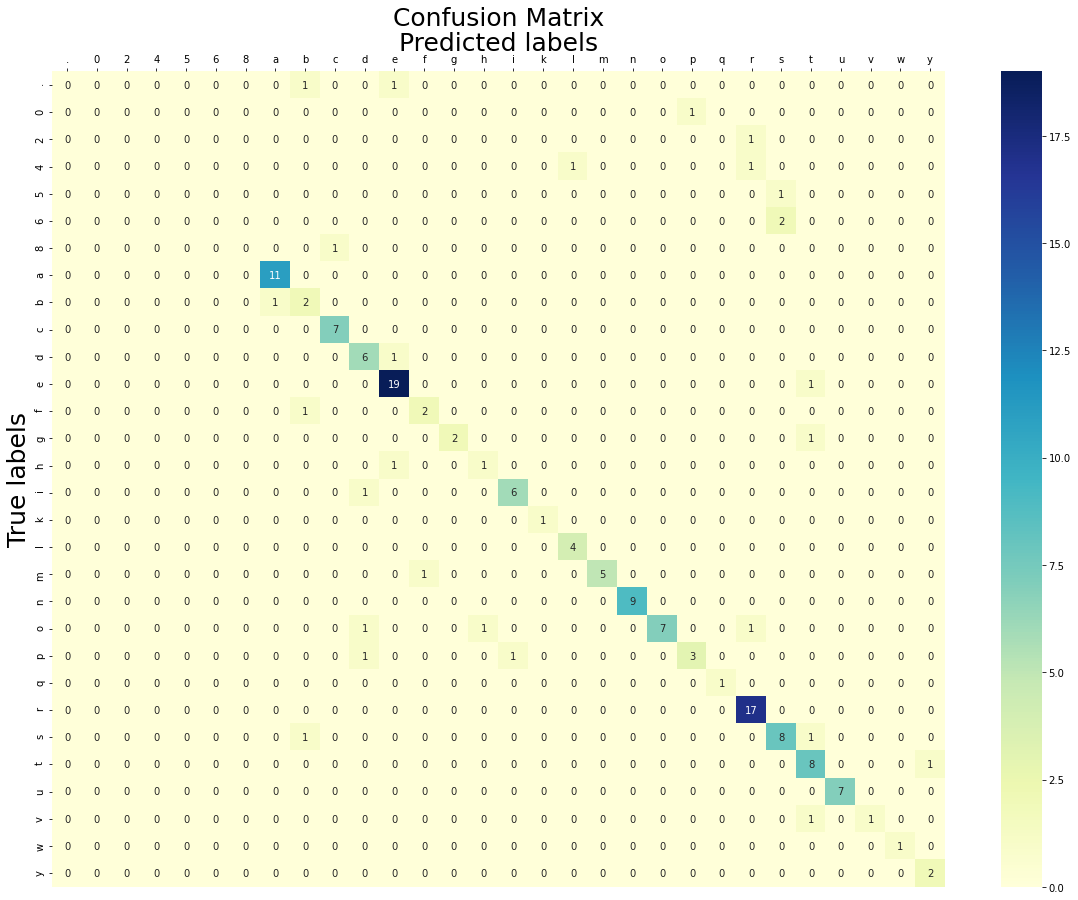

In [ ]:
f = plt.figure(figsize=(20,15))
#f=plt.fifure(fontsize=25)
ax= f.add_subplot()
h=sns.heatmap(CM_overall, annot=True, ax = ax,cmap="YlGnBu"); #annot=True to annotate cells
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize=25);ax.set_ylabel('True labels',fontsize=25); 
ax.set_title('Confusion Matrix',fontsize=25); 
ax.xaxis.set_ticklabels(sorted(list(set(orig_characters))),fontsize=10); ax.yaxis.set_ticklabels(sorted(list(set(orig_characters))),fontsize=10);
#f.savefig("o.png")

In [ ]:
final_paths = []
final_texts = []

data_folder = "TestImages_EAST"
for path in os.listdir(data_folder):


    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split(".png")[0])


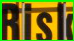


 original Risk 

predicted text = Risf
 Risf 



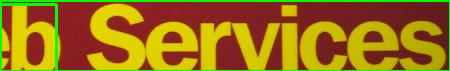


 original Services 

predicted text = Bsenices
 Bsenices 



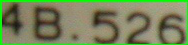


 original 4B.526 

predicted text = ABspS
 ABspS 



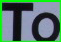


 original To 

predicted text = To
 To 



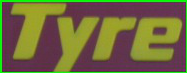


 original Tyre 

predicted text = LXMLS
 LXMLS 



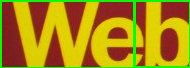


 original Web 

predicted text = rted
 rted 



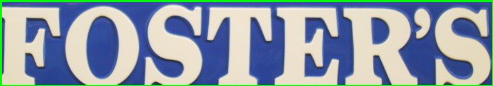


 original FOSTERS'S 

predicted text = HOSTERS
 HOSTERS 



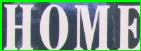


 original HOME 

predicted text = HOE
 HOE 



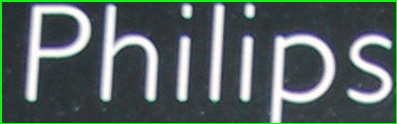


 original Philips 

predicted text = Philips
 Philips 



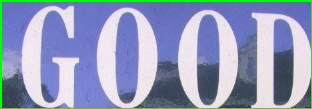


 original GOOD 

predicted text = GOOD
 GOOD 



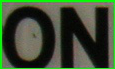


 original ON 

predicted text = CON
 CON 



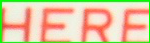


 original HERE 

predicted text = LRRE
 LRRE 




 original CASK 

predicted text = CAH
 CAH 




 original CHILDREN 

predicted text = DhILDRER
 DhILDRER 



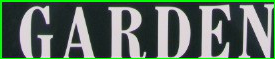


 original GARDEN 

predicted text = FARDEN
 FARDEN 



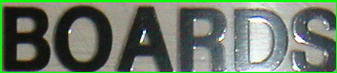


 original BOARDS 

predicted text = BOARDS
 BOARDS 



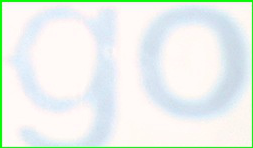


 original go 

predicted text = CD
 CD 



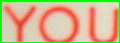


 original YOU 

predicted text = ROLI
 ROLI 



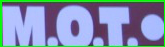


 original M.O.T. 

predicted text = Miorc
 Miorc 



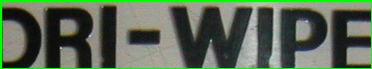


 original DRI_WIPE 

predicted text = rlewipe
 rlewipe 



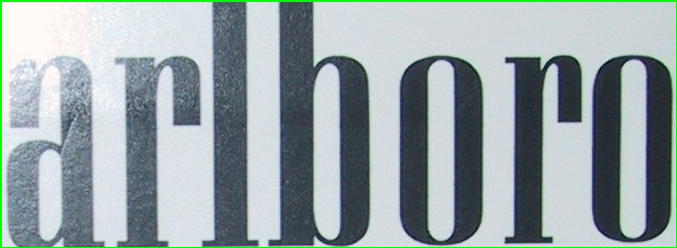


 original arlboro 

predicted text = arihoeo
 arihoeo 



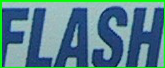


 original FLASH 

predicted text = ELASLI
 ELASLI 



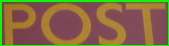


 original POST 

predicted text = POST
 POST 



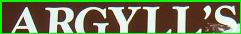


 original ARGYLL'S 

predicted text = aRAyLeS
 aRAyLeS 



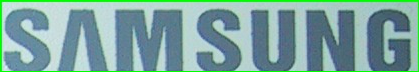


 original SAMSUNG 

predicted text = SAMSUNG
 SAMSUNG 



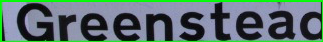


 original Greenstead 

predicted text = Creensteac
 Creensteac 



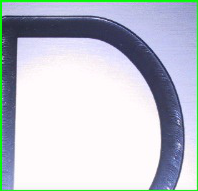


 original D 

predicted text = Td
 Td 



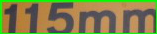


 original 115mm 

predicted text = dimm
 dimm 




 original MORTAGES 

predicted text = MORTGAGES
 MORTGAGES 



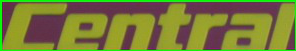


 original Central 

predicted text = Fentral
 Fentral 



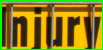


 original Injury 

predicted text = Inuri
 Inuri 



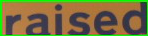


 original raised 

predicted text = raised
 raised 



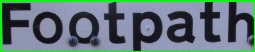


 original Footpath 

predicted text = Footpath
 Footpath 



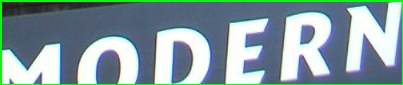


 original MODERN 

predicted text = BODERN
 BODERN 



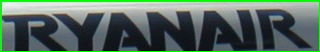


 original RYANAIR 

predicted text = RANAR
 RANAR 



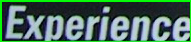


 original Experience 

predicted text = Experience
 Experience 



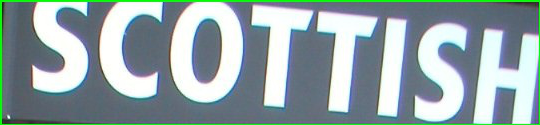


 original NATIONAL 

predicted text = sCOrTISH
 sCOrTISH 



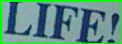


 original LIFE! 

predicted text = LRBE
 LRBE 



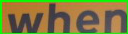


 original when 

predicted text = whan
 whan 



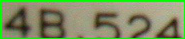


 original 4B.524 

predicted text = apoA
 apoA 



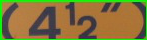


 original (412) 

predicted text = Calps
 Calps 



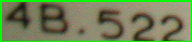


 original 4B.522 

predicted text = ABpD
 ABpD 



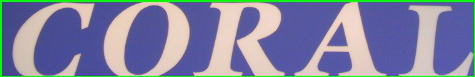


 original CORAL 

predicted text = CORAT
 CORAT 



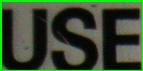


 original USE 

predicted text = LSE
 LSE 




 original KEEP 

predicted text = KEEP
 KEEP 



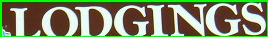


 original LODGINGS 

predicted text = LODGINGS
 LODGINGS 



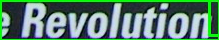


 original Revolution 

predicted text = Revolutionl
 Revolutionl 



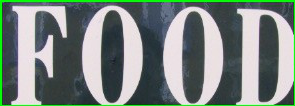


 original FOOD 

predicted text = FOOD
 FOOD 



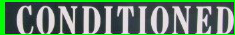


 original CONDITIONED 

predicted text = CONDITIONED
 CONDITIONED 



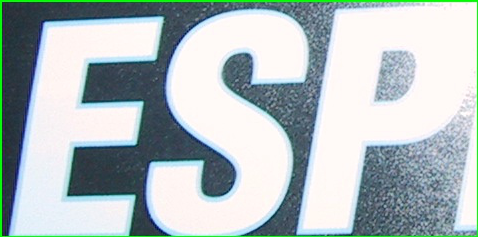


 original ESP 

predicted text = Fuen
 Fuen 



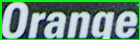


 original Orange 

predicted text = Oranae
 Oranae 



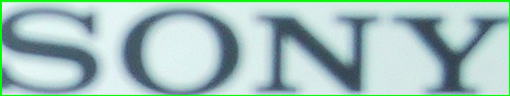


 original SONY 

predicted text = SONY
 SONY 



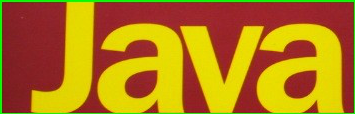


 original Java 

predicted text = savva
 savva 



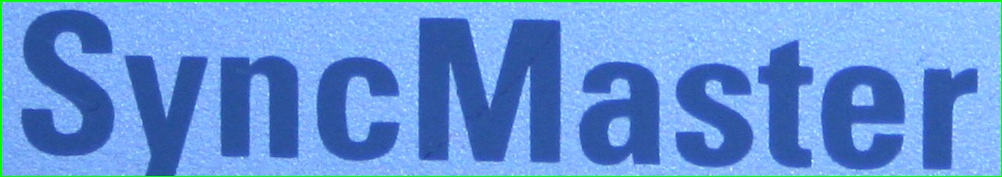


 original SyncMaster 

predicted text = Syncmaster
 Syncmaster 



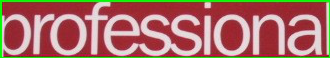


 original professional 

predicted text = orofessiona
 orofessiona 




 original STIRLING 

predicted text = STRLING
 STRLING 



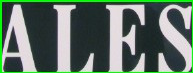


 original ALES 

predicted text = ATRS
 ATRS 



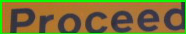


 original Proceed 

predicted text = Proceed
 Proceed 




 original caution. 

predicted text = cautionn
 cautionn 



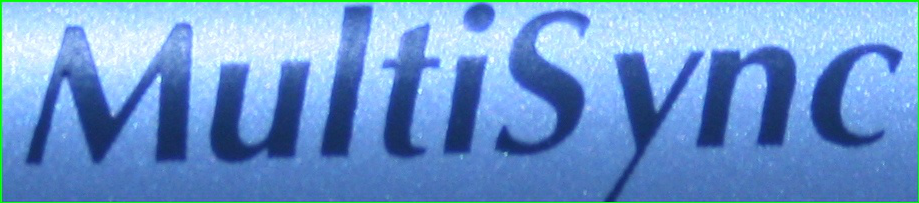


 original MultiSync 

predicted text = Multisyne
 Multisyne 



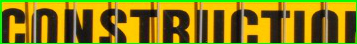


 original CONSTRUCTION 

predicted text = AnngtRlIctIAD
 AnngtRlIctIAD 



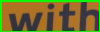


 original with 

predicted text = with
 with 



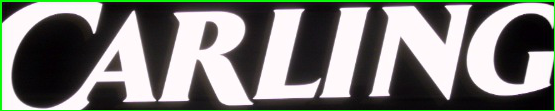


 original CARLING 

predicted text = CARLING
 CARLING 



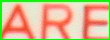


 original ARE 

predicted text = aRE
 aRE 



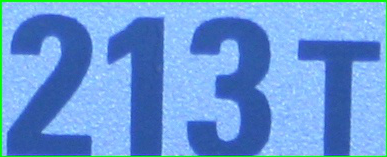


 original 213T 

predicted text = DABIR
 DABIR 



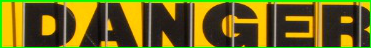


 original DANGER 

predicted text = DJLNGSR
 DJLNGSR 



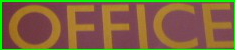


 original OFFICE 

predicted text = OFFICE
 OFFICE 



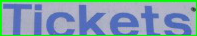


 original Tickets 

predicted text = Tickets
 Tickets 



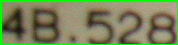


 original 4B.528 

predicted text = aBEpE
 aBEpE 



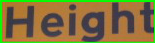


 original Height 

predicted text = Height
 Height 



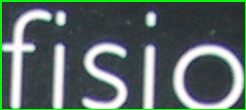


 original fisio 

predicted text = Fisio
 Fisio 



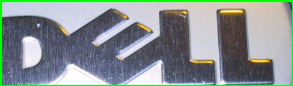


 original DELL 

predicted text = DIL
 DIL 



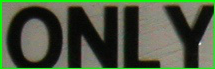


 original ONLY 

predicted text = ONLY
 ONLY 




 original PENSIONS 

predicted text = PENSIONS
 PENSIONS 



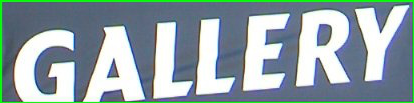


 original GALLERY 

predicted text = GALLERY
 GALLERY 



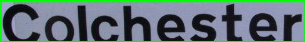


 original Colchester 

predicted text = Colchester
 Colchester 



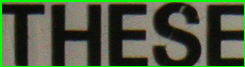


 original THESE 

predicted text = THESE
 THESE 




 original CASTLE 

predicted text = RASTLE
 RASTLE 



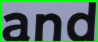


 original and 

predicted text = and
 and 




 original OUT 

predicted text = Mly
 Mly 



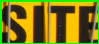


 original SITE 

predicted text = ESITR
 ESITR 



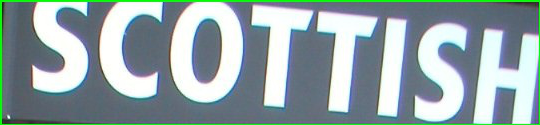


 original SCOTTISH 

predicted text = sCOrTISH
 sCOrTISH 



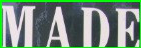


 original MADE 

predicted text = MHADE
 MHADE 



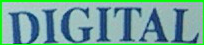


 original DIGITAL 

predicted text = DICITAL
 DICITAL 



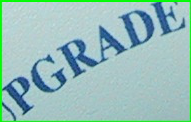


 original UPGRADE 

predicted text = SEAY
 SEAY 



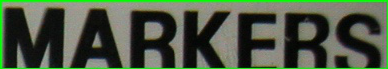


 original MARKERS 

predicted text = MARKERS
 MARKERS 



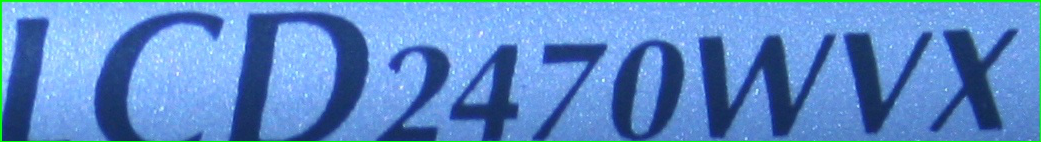


 original LCD2470WVX 

predicted text = HCDoasownk
 HCDoasownk 



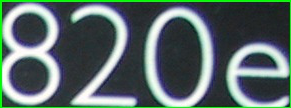


 original 820e 

predicted text = Se
 Se 



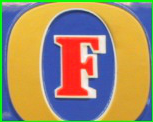


 original F 

predicted text = CCED
 CCED 



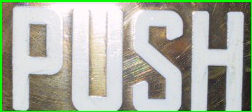


 original PUSH 

predicted text = PlESey
 PlESey 



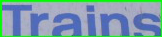


 original Trains 

predicted text = Trainc
 Trainc 




 original YOUR 

predicted text = YnuE
 YnuE 




 original INVESTMENTS 

predicted text = NVESTMENS
 NVESTMENS 




 original Information 

predicted text = Infarmatiann
 Infarmatiann 



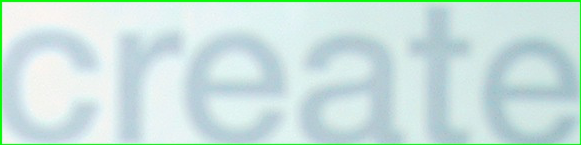


 original create 

predicted text = create
 create 



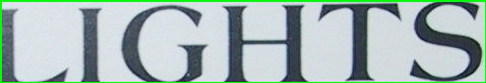


 original LIGHTS 

predicted text = LGHTS
 LGHTS 



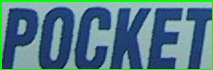


 original POCKET 

predicted text = POCKET
 POCKET 



In [ ]:
from IPython.display import display
from random import randrange
actual=[]
pred=[]
for i in range(len(final_paths)):
    #index = randrange(len(val_final_paths))
    im = Image.open(final_paths[i])
    display(im)
    original =  final_texts[i]
    actual.append(original)
    print("\n original",original,"\n")


    test_img = pre_process_image(final_paths[i])
    prediction=predict_output(test_img)
    pred.append(prediction)

In [ ]:
act_lower=[]
pred_lower=[]
for i in range(len(actual)):
  act_lower.append(actual[i].lower())
  pred_lower.append(pred[i].lower())

OverallAcc = accuracy_score(act_lower,pred_lower)
OverallAcc

0.32989690721649484

In [ ]:
total = 0
dist=[]
for i in range(len(act_lower)):
  k=editdistance.eval(act_lower[i], pred_lower[i])
  dist.append(k)
  total+=k
print(total,total/len(act_lower))



172 1.7731958762886597


In [ ]:
orig_characters = []
pred_characters = []
for i in range(len(act_lower)):
  if len(actual[i])==len(pred[i]):
    a= list(act_lower[i])
    b = list(pred_lower[i])
    orig_characters+=a
    pred_characters+=b

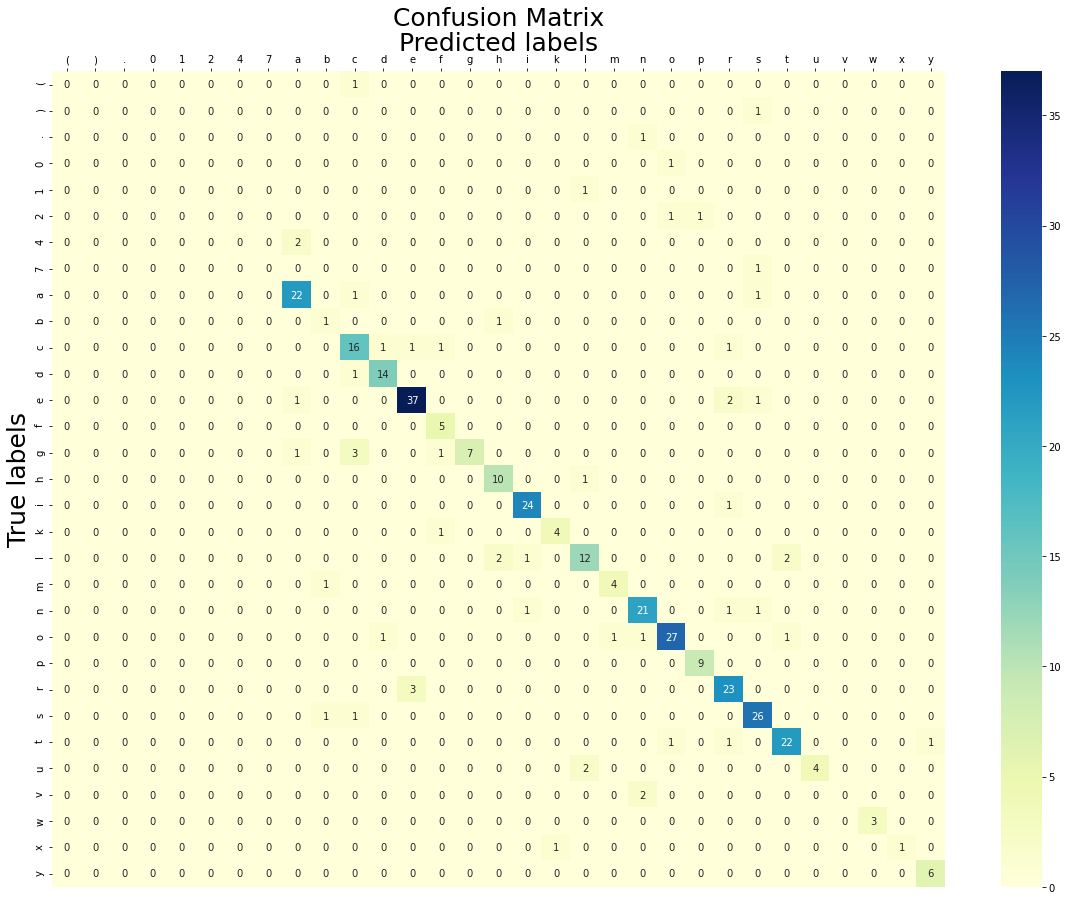

In [ ]:
CM_overall = confusion_matrix(orig_characters,pred_characters)
f = plt.figure(figsize=(20,15))
#f=plt.fifure(fontsize=25)
ax= f.add_subplot()
h=sns.heatmap(CM_overall, annot=True, ax = ax,cmap="YlGnBu"); #annot=True to annotate cells
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
# labels, title and ticks
ax.set_xlabel('Predicted labels',fontsize=25);ax.set_ylabel('True labels',fontsize=25); 
ax.set_title('Confusion Matrix',fontsize=25); 
ax.xaxis.set_ticklabels(sorted(list(set(orig_characters))),fontsize=10); ax.yaxis.set_ticklabels(sorted(list(set(orig_characters))),fontsize=10);
#f.savefig("o.png")

In [ ]:
import string
characters=list(string.ascii_lowercase)

'Castle'

## Verification of results on YOLO, EAST and OCR text detection MODELS

In [ ]:
def Verification(Folder):
  final_paths = []
  final_texts = []

  data_folder = Folder
  for path in os.listdir(data_folder):
    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split(".png")[0])
  actual=[]
  pred=[]
  for i in range(len(final_paths)):
      #index = randrange(len(val_final_paths))
      #im = Image.open(final_paths[i])
      #display(im)
      original =  final_texts[i]
      actual.append(original)
      #print("\n original",original,"\n")


      test_img = pre_process_image(final_paths[i])
      prediction=predict_output(test_img)
      pred.append(prediction)
  act_lower=[]
  pred_lower=[]
  for i in range(len(actual)):
    act_lower.append(actual[i].lower())
    pred_lower.append(pred[i].lower())

  OverallAcc = accuracy_score(act_lower,pred_lower)
  print("Accuracy ",OverallAcc)
  total = 0
  dist=[]
  for i in range(len(act_lower)):
    k=editdistance.eval(act_lower[i], pred_lower[i])
    dist.append(k)
    total+=k
  print("edit distance",total,total/len(act_lower))
  orig_characters = []
  pred_characters = []
  for i in range(len(act_lower)):
    if len(actual[i])==len(pred[i]):
      a= list(act_lower[i])
      b = list(pred_lower[i])
      orig_characters+=a
      pred_characters+=b
  CM_overall = confusion_matrix(orig_characters,pred_characters,characters)
  f = plt.figure(figsize=(20,15))
  #f=plt.fifure(fontsize=25)
  ax= f.add_subplot()
  h=sns.heatmap(CM_overall, annot=True, ax = ax,cmap="YlGnBu"); #annot=True to annotate cells
  ax.xaxis.set_label_position('top') 
  ax.xaxis.tick_top()
  # labels, title and ticks
  ax.set_xlabel('Predicted labels',fontsize=25);ax.set_ylabel('True labels',fontsize=25); 
  ax.set_title('Confusion Matrix',fontsize=25); 
  ax.xaxis.set_ticklabels(characters,fontsize=10); ax.yaxis.set_ticklabels(characters,fontsize=10);
  f.savefig(Folder+".png")
  print(classification_report(orig_characters, pred_characters, labels=characters))



Accuracy  0.2892561983471074
edit distance 227 1.8760330578512396


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           a       0.87      1.00      0.93        26
           b       0.36      0.67      0.47         6
           c       0.83      0.94      0.88        16
           d       0.73      0.85      0.79        13
           e       0.84      0.91      0.87        45
           f       0.50      0.67      0.57         6
           g       1.00      0.75      0.86         8
           h       0.83      0.62      0.71         8
           i       0.96      0.88      0.92        25
           j       0.00      0.00      0.00         0
           k       1.00      0.67      0.80         3
           l       0.64      0.88      0.74        16
           m       0.91      0.91      0.91        11
           n       1.00      0.96      0.98        24
           o       0.88      0.81      0.85        27
           p       0.67      0.57      0.62         7
           q       1.00      1.00      1.00         1
           r       0.83    

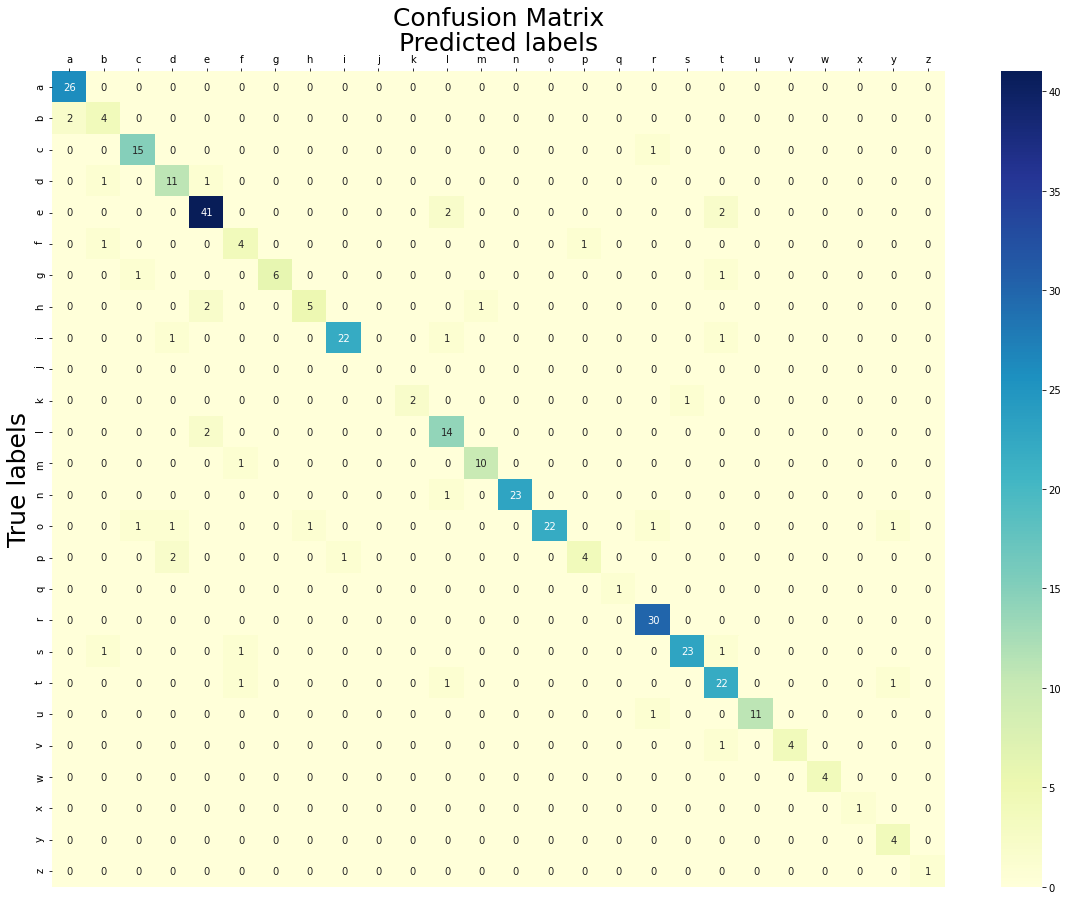

In [ ]:
Verification('yolo_test')

Accuracy  0.32989690721649484
edit distance 172 1.7731958762886597


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           a       0.85      0.92      0.88        24
           b       0.33      0.50      0.40         2
           c       0.70      0.80      0.74        20
           d       0.88      0.93      0.90        15
           e       0.90      0.90      0.90        41
           f       0.62      1.00      0.77         5
           g       1.00      0.58      0.74        12
           h       0.77      0.91      0.83        11
           i       0.92      0.96      0.94        25
           j       0.00      0.00      0.00         0
           k       0.80      0.80      0.80         5
           l       0.75      0.71      0.73        17
           m       0.80      0.80      0.80         5
           n       0.84      0.88      0.86        24
           o       0.90      0.87      0.89        31
           p       0.90      1.00      0.95         9
           q       0.00      0.00      0.00         0
           r       0.79    

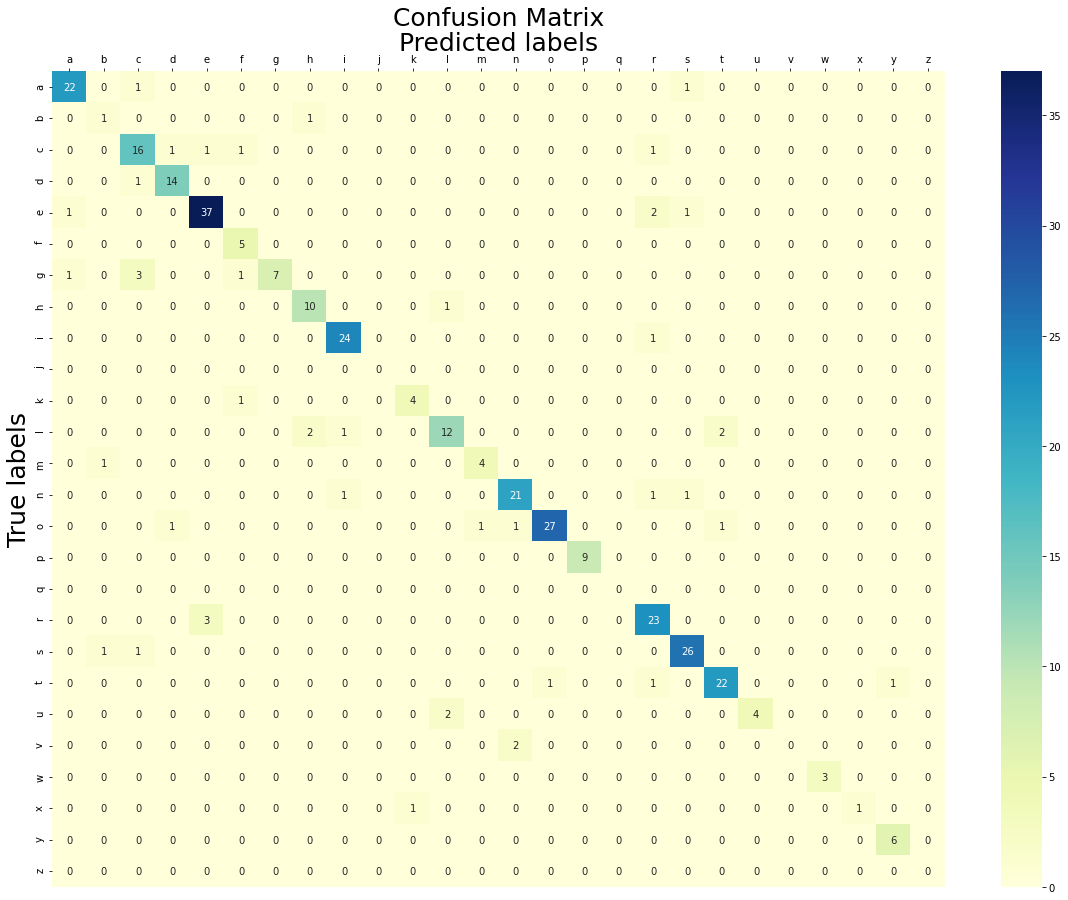

In [ ]:
Verification("TestImages_EAST")

## ocr

In [ ]:
!pip3 install easyocr --no-deps # Colab already has all dependencies
!pip3 install python-bidi

import easyocr
reader = easyocr.Reader(['en'])

In [ ]:
def Verification_OCR(Folder):
  final_paths = []
  final_texts = []

  data_folder = Folder
  for path in os.listdir(data_folder):
    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split(".png")[0])
  actual=[]
  pred=[]
  for i in range(len(final_paths)):
      #index = randrange(len(val_final_paths))
      #im = Image.open(final_paths[i])
      #display(im)
      try:
        bounds = reader.readtext(final_paths[i])
        #print(bounds,final_paths[i])
        prediction=bounds[0][1]
      except:
        continue
      pred.append(prediction)
      original =  final_texts[i]
      actual.append(original)
      #print(original,prediction)


      #test_img = pre_process_image(final_paths[i])
      
  act_lower=[]
  pred_lower=[]
  for i in range(len(actual)):
    act_lower.append(actual[i].lower())
    pred_lower.append(pred[i].lower())

  OverallAcc = accuracy_score(act_lower,pred_lower)
  print("Accuracy ",OverallAcc)
  total = 0
  dist=[]
  for i in range(len(act_lower)):
    k=editdistance.eval(act_lower[i], pred_lower[i])
    dist.append(k)
    total+=k
  print("edit distance",total,total/len(act_lower))
  orig_characters = []
  pred_characters = []
  for i in range(len(act_lower)):
    if len(actual[i])==len(pred[i]):
      a= list(act_lower[i])
      b = list(pred_lower[i])
      orig_characters+=a
      pred_characters+=b
  CM_overall = confusion_matrix(orig_characters,pred_characters,characters)
  f = plt.figure(figsize=(20,15))
  #f=plt.fifure(fontsize=25)
  ax= f.add_subplot()
  h=sns.heatmap(CM_overall, annot=True, ax = ax,cmap="YlGnBu"); #annot=True to annotate cells
  ax.xaxis.set_label_position('top') 
  ax.xaxis.tick_top()
  # labels, title and ticks
  ax.set_xlabel('Predicted labels',fontsize=25);ax.set_ylabel('True labels',fontsize=25); 
  ax.set_title('Confusion Matrix',fontsize=25); 
  ax.xaxis.set_ticklabels(characters,fontsize=10); ax.yaxis.set_ticklabels(characters,fontsize=10);
  f.savefig("ocr.png")

  print(classification_report(orig_characters, pred_characters, labels=characters))


Accuracy  0.5213675213675214
edit distance 151 1.2905982905982907


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           a       1.00      0.94      0.97        34
           b       0.90      0.90      0.90        10
           c       1.00      1.00      1.00        19
           d       1.00      0.92      0.96        13
           e       0.98      0.88      0.93        58
           f       0.82      0.90      0.86        10
           g       0.87      1.00      0.93        13
           h       0.68      0.87      0.76        15
           i       0.94      1.00      0.97        29
           j       0.00      0.00      0.00         0
           k       0.83      1.00      0.91         5
           l       0.78      0.95      0.86        19
           m       1.00      1.00      1.00        12
           n       0.93      0.96      0.95        27
           o       0.92      1.00      0.96        33
           p       0.75      0.75      0.75         8
           q       0.33      1.00      0.50         1
           r       1.00    

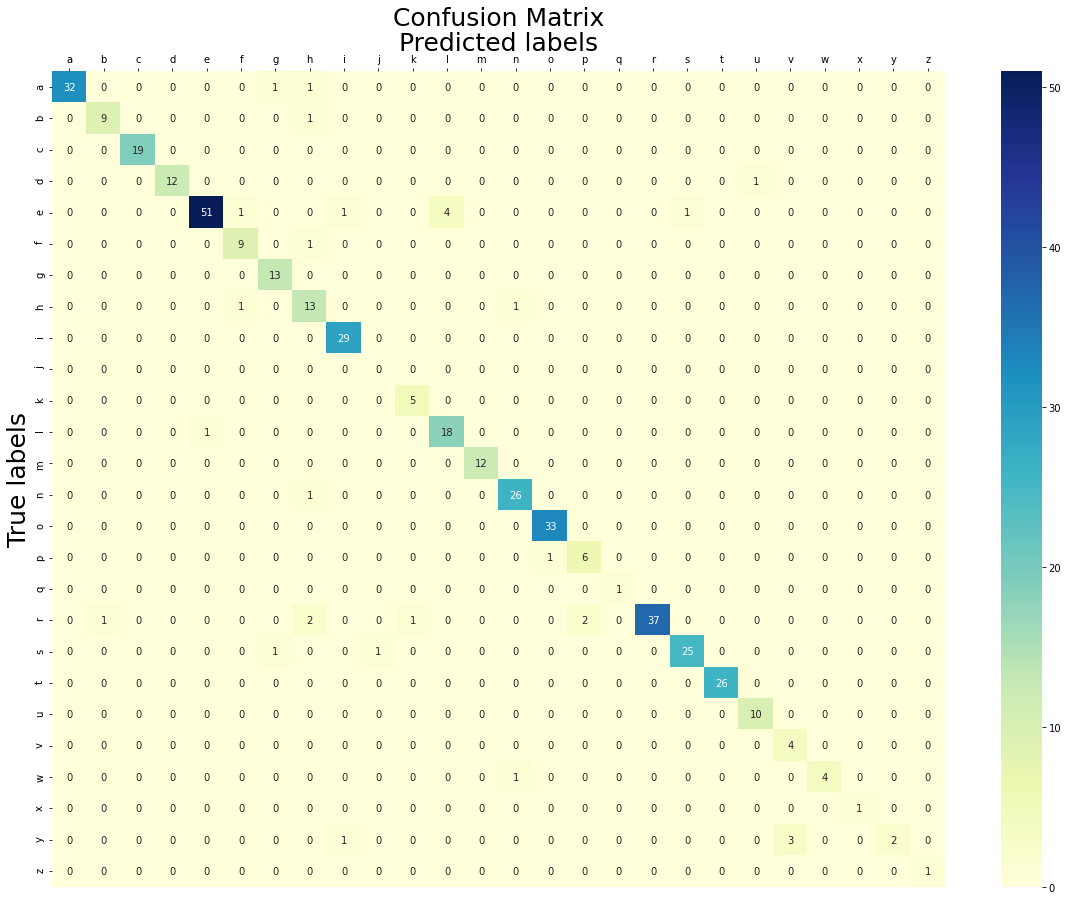

In [ ]:
Verification_OCR("yolo_test")

Accuracy  0.3684210526315789
edit distance 183 1.9263157894736842


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           a       0.92      0.81      0.86        27
           b       1.00      0.50      0.67         2
           c       0.71      1.00      0.83        15
           d       0.87      0.93      0.90        14
           e       1.00      0.84      0.92        45
           f       0.45      0.83      0.59         6
           g       1.00      0.60      0.75        10
           h       1.00      0.83      0.91        12
           i       0.84      0.96      0.90        27
           j       1.00      1.00      1.00         1
           k       1.00      0.80      0.89         5
           l       0.92      0.80      0.86        15
           m       0.82      0.90      0.86        10
           n       0.75      0.89      0.81        27
           o       0.94      0.94      0.94        31
           p       0.77      0.83      0.80        12
           q       0.00      0.00      0.00         0
           r       1.00    

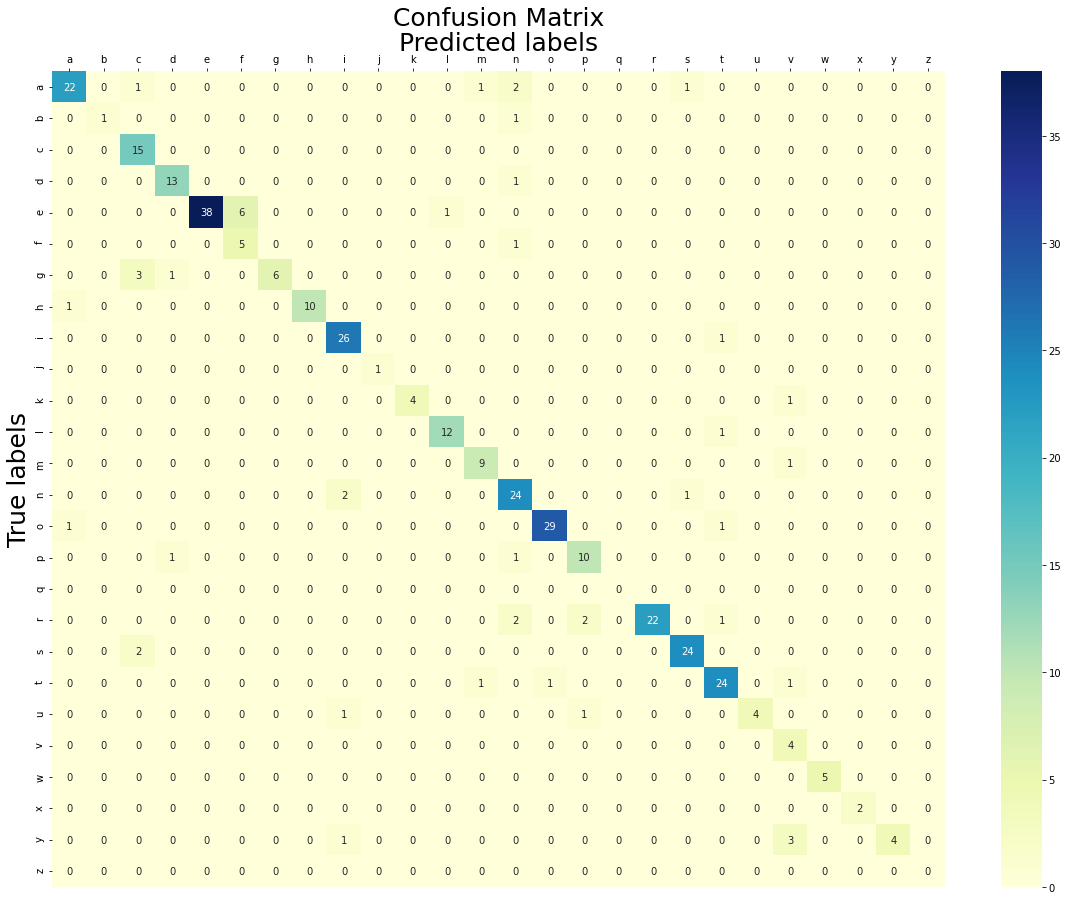

In [ ]:
Verification_OCR("TestImages_EAST")